## Weight Initialization

> why does good initialization matter in neural networks and what are vanishing gradients


You want to solve a problem using deep learning. You have collected a dataset, decided on a neural network architecture, loss function, optimizer and some metrics you want to evaluate on. While training you notice your network isn't performing well, neither on train nor validation dataset. Looking for bugs while training neural networks is not a simple task, so we break down the whole training process into separate pipelines. Let's start by looking for bugs in our architecture and the way we initialize our weights.

#### Problem: Why does good initialization matter?

- As Neural Networks involve a lot of matrix multiplications, the mean and variance of activations can quickly shoot off to very high values or drop down to zero. 
- This will cause the local gradients of our layers to become NaN or zero and hence prevent our network from learning anything . 
- A common strategy to avoid this is to initialize the weights of your network using the latest techniques.
- Different activations require different initializations:
    - Xavier (Glorot) Initialization: Best for tanh/sigmoid activations, maintaining variance across layers.
    - He Initialization: Best for ReLU/Leaky ReLU, scaling variance to account for zeroing-out of half the values.

![img](https://adityassrana.github.io/blog/images/copied_from_nb/images/local_gradients_backprop.png)

> Upstream gradients are multiplied by local gradients to get the downstream gradients during backprop

![img](https://adityassrana.github.io/blog/images/copied_from_nb/images/act_derivative.png)

![img](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*gkXI7LYwyGPLU5dn6Jb6Bg.png)

- Notice how the gradients in both sigmoid and tanh are non-zero only inside a certain range between [-5, 5]
    - Outside this range, the gradients approach zero, which makes training difficult.

- Another non-obvious fun fact about sigmoid is that its local gradient (z*(1-z)) achieves a maximum at 0.25, when z = 0.5. That means that every time the gradient signal flows through a sigmoid gate, its magnitude always diminishes by one quarter (or more). If you’re using basic SGD, this would make the lower layers of a network train much slower than the higher ones.
    - Why does this matter? - In deep networks, gradients pass through multiple sigmoid activations, leading to an exponential decay in gradient magnitude.

- tanh is slightly better than sigmoid, why?
    - Since tanh is zero-centered, it avoids some of the issues caused by sigmoid’s strictly positive outputs. 
    - However, it still suffers from vanishing gradients for large or small inputs.

## Task at Hand

- To ensure the gradients of our network do not explode or diminish to zero
- The Mean of activations should be zero
- The Variance of activations should stay same across layers.

> Intitalizing the network with the right weights can make the difference between converging in a few epochs versus not converging at all

## Solution: The right weight initialization

### 1. All weights and biases are initialized to zero

- Do not ever do this! 

- In such a case, all neurons of a layer would end up computing the same output, will receive the same gradients during backpropagation and undergo the same parameter updates. 

- That means that all neurons of a layer will be learning the same features during training as there is no symmetry breaking. 

- Also The problem with zero initialized layer is that since its output will be zero, it will halt the gradient flow at the next layer by making the local gradients of weights for the next layer zero.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
plt.style.use('seaborn')

### Using Small Random Numbers from a Normal Distribution

Why Normal/Gaussian? Because it is characterized by its mean and variance, exactly the two things we want to control and compare

- Neural networks involve repeated matrix multiplications in forward propagation.
- If the variance of weights is too large, activations will grow exponentially → Exploding Activations → Exploding Gradients → Unstable training.
- If the variance of weights is too small, activations shrink toward zero → Vanishing Activations → Lower layers stop learning.
- The goal is to maintain a consistent variance across layers, preventing both exploding and vanishing activations.

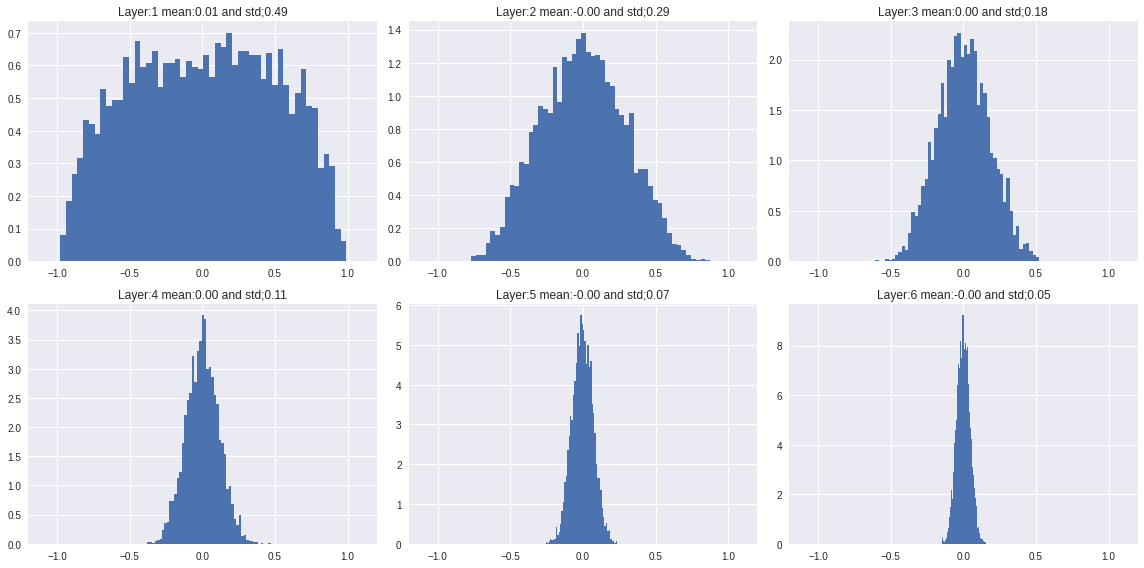

In [ ]:
dims = [4096]*7
mean = []
std =  []
hist = []
x = np.random.randn(dims[0])
for Din, Dout in zip(dims[:-1],dims[1:]):
    #Focus here
    W = 0.01*np.random.randn(Din,Dout)
    x = np.tanh(x.dot(W))
    mean.append(x.mean())
    std.append(x.std())
    hist.append(x)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
for i,ax,m,s in zip(np.arange(6),axes.flatten(),mean,std):
    ax.hist(hist[i],density = True,bins=50)
    ax.set_xlim(-1.2,1.2)
    ax.set_title(f'Layer:{i+1} mean:{m:.2f} and std;{s:.2f}')
plt.tight_layout()

### Why and when do gradients vanish?

As all activations tend to zero for deeper layers, the gradients are going to collapse to zero as well. Why?

![img](https://adityassrana.github.io/blog/images/copied_from_nb/images/local_gradients_backprop.png)

- Because whenever we compute local gradient on the weight, the local gradient of the weight is going to be equal to to the activation of the previous layer. 

- So this means for a deep network, if the activations before a layer collapse to zero, the local gradients on the weight collapse as well and the network will stop learning. 

- That's why for gradients to stop vanishing or exploding it's important to prevent activations from vanishing or exploding respectively.

#### At the last layer:

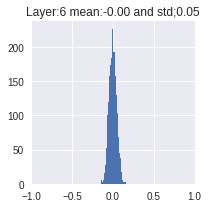

In [ ]:
fig, ax = plt.subplots(figsize=(3,3))
ax.hist(hist[5],bins=50)
ax.set_title(f'Layer:{6} mean:{m:.2f} and std;{s:.2f}')
ax.set_xlim(-1,1)
plt.tight_layout()

As we can  see, most of the activations in the last layer are around zero.

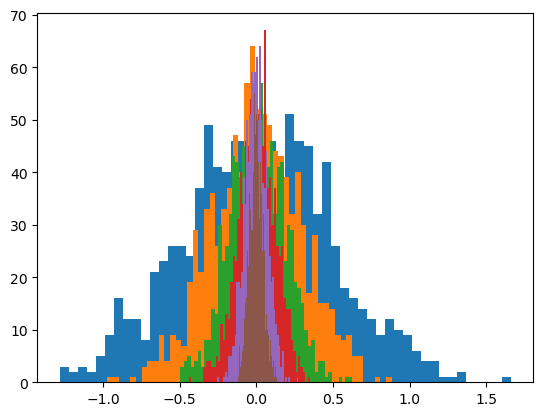

In [ ]:
plt.style.use('default')
for m,s in zip(mean,std):
    a = np.random.normal(m,s,size=1000)
    plt.hist(a,bins=50)

### Maybe larger weights will not get diminished

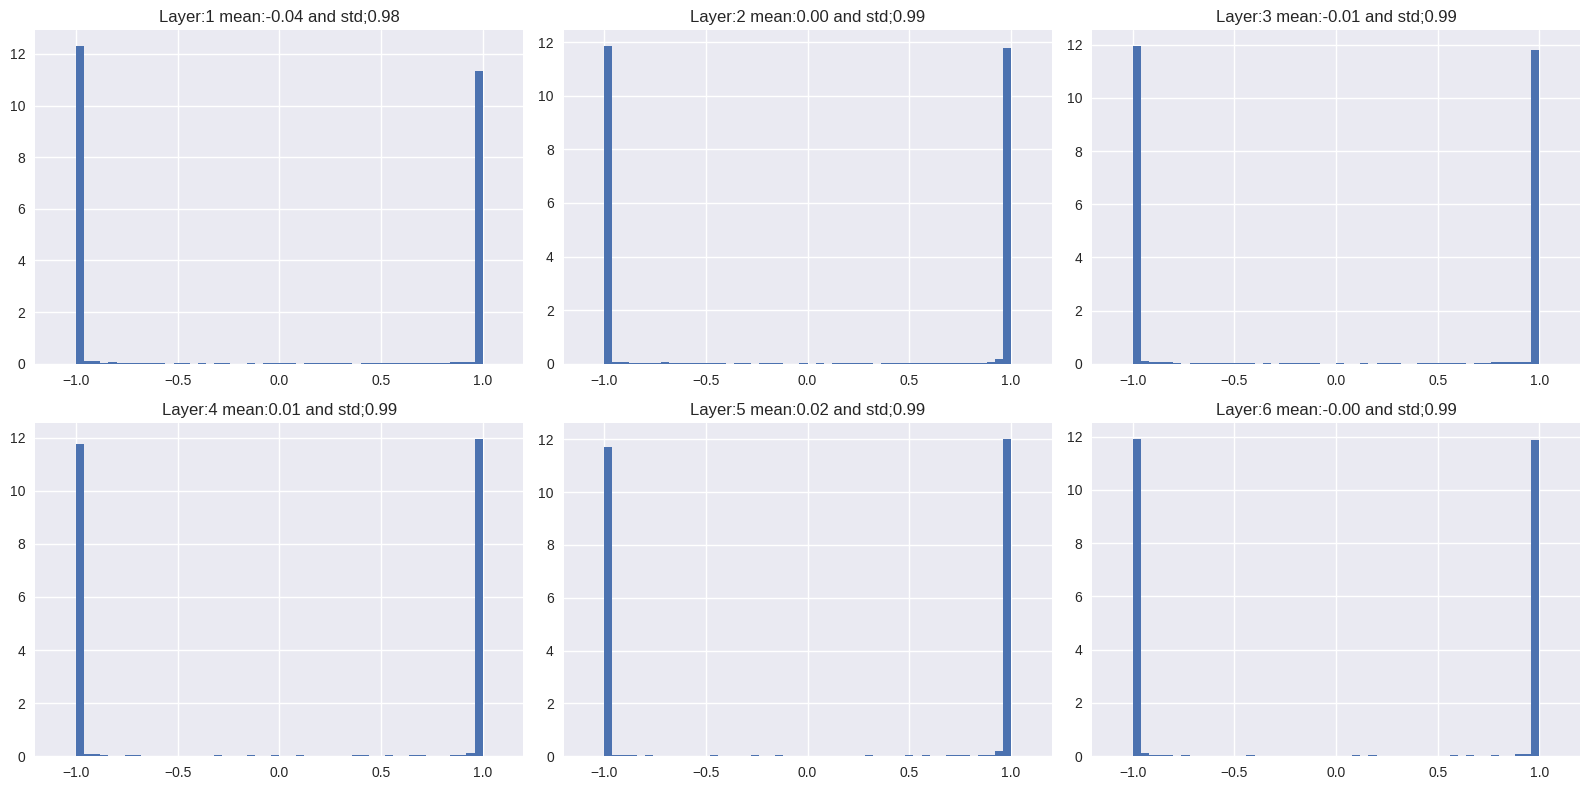

In [ ]:
dims = [4096]*7
mean = []
std =  []
hist = []
x = np.random.randn(dims[0])
for Din, Dout in zip(dims[:-1],dims[1:]):
    W = 0.5*np.random.randn(Din,Dout) # previous W = 0..1 * np.random.randn(Din,Dout)
    x = np.tanh(x.dot(W))
    mean.append(x.mean())
    std.append(x.std())
    hist.append(x)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
for i,ax,m,s in zip(np.arange(6),axes.flatten(),mean,std):
    ax.hist(hist[i],density = True,bins=50)
    ax.set_xlim(-1.2,1.2)
    ax.set_title(f'Layer:{i+1} mean:{m:.2f} and std;{s:.2f}')
plt.tight_layout()

Wow, that was a disaster. All neurons are saturated and are outputting -1s and 1s where gradient is zero. Again, no learning

### Xavier : Magic Scaling Number  $$\sqrt{\frac{1}{Din}}$$

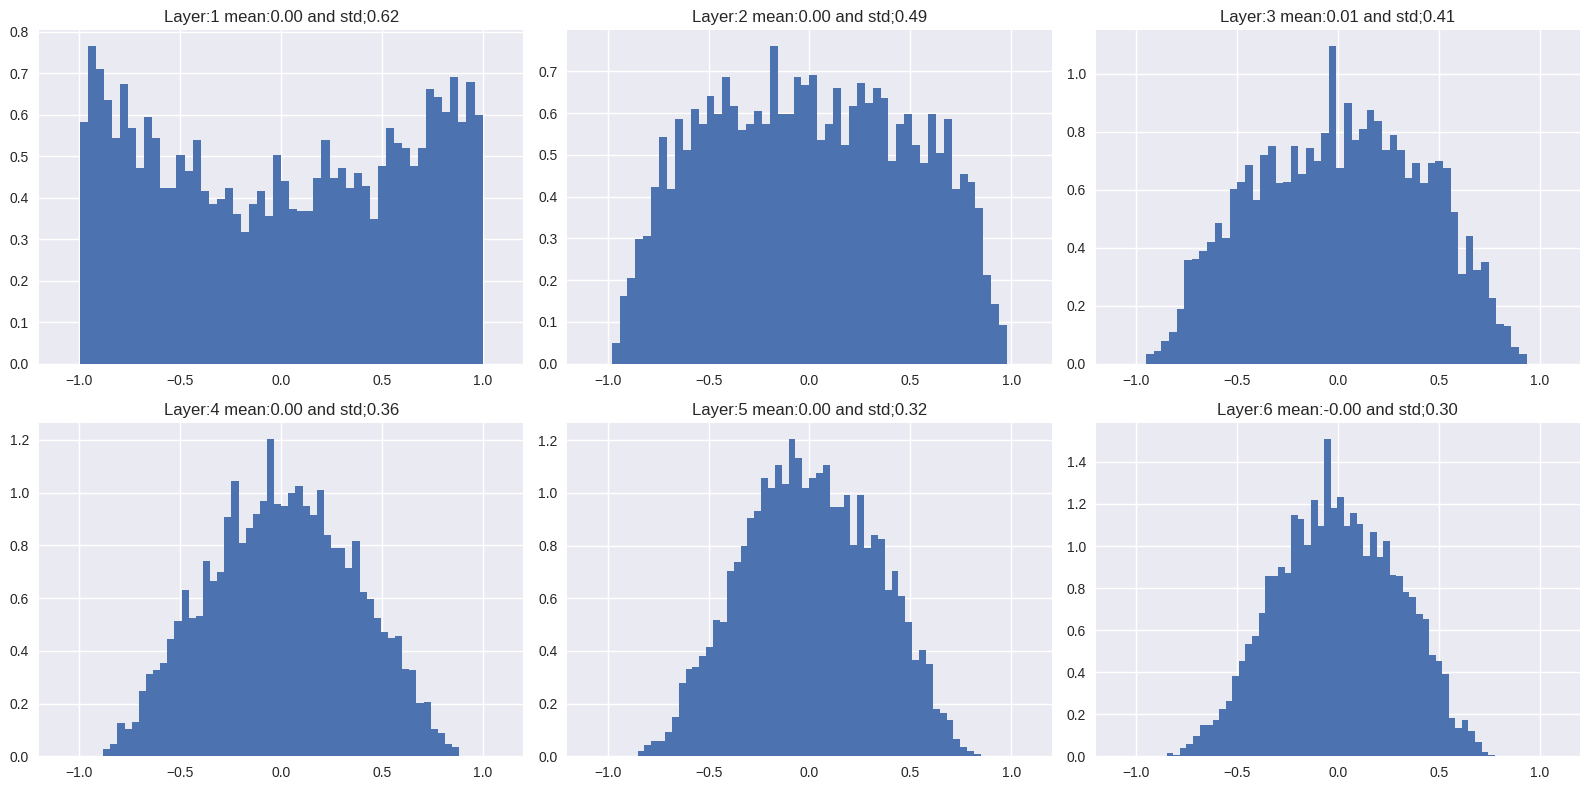

In [ ]:
dims = [4096]*7
mean = []
std =  []
hist = []
x = np.random.randn(dims[0])
for Din, Dout in zip(dims[:-1],dims[1:]):
    W = np.random.randn(Din,Dout)/np.sqrt(Din)
    x = np.tanh(x.dot(W))
    mean.append(x.mean())
    std.append(x.std())
    hist.append(x)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
for i,ax,m,s in zip(np.arange(6),axes.flatten(),mean,std):
    ax.hist(hist[i],density = True,bins=50)
    ax.set_xlim(-1.2,1.2)
    ax.set_title(f'Layer:{i+1} mean:{m:.2f} and std;{s:.2f}')
plt.tight_layout()

Hmmmmmmmmm, why did that work? This was proposed in [Understanding the difficulty of training deep feedforward neural networks](http://proceedings.mlr.press/v9/glorot10a.html), the 2010 paper that introduced ‘Xavier initialization’ which we have just used.

But where does it come from? It's not that mysterious if you remember the definition of the matrix multiplication. When we do `y = x @ W`, the coefficients of `y` are defined by

$$y_{i} =  x_{1} w_{1} + x_{2} w_{2} + \cdots + x_{n} w_{n} = \sum_{j=1}^{Din} x_{j} w_{j} $$


Now at the very beginning, our `x` vector has a mean of roughly 0. and a standard deviation of roughly 1. (since we picked it that way).

$$ Var(y_{i}) = Var(x_{1} w_{1} + x_{2} w_{2} + \cdots + x_{n} w_{n}) $$

1. Assume x, w are iid $$ Var(y_{i}) = D_{in} * Var(x_{i} w_{i}) $$
2. Assume x, w independent $$ Var(y_{i}) = D_{in} * (E[x_{i}^2] E[w_{i}^2] - E[x_{i}]^2 E[w_{i}]^2) $$
3. Assume x, w are zero-mean $$ Var(y_{i}) = D_{in} * Var(x_{i}) * Var(w_{i}) $$

Hence for the variances to remain same between layers that is $$ Var(y_{i}) = Var(x_{i})$$ the condition is  $$ Var(w_i) = \frac{1}{Din} $$

That's it, the Xavier initialization.

### Kaiming Initialization, if using ReLU scale by $$\sqrt{\frac{2}{Din}}$$

Xavier initialization assumes the input to have zero mean, but things change when we use a ReLU which sets all negative values to zero. Let's see what happens if we continue using Xavier initialization with ReLU

#### Why is there a 2 in the Kaiming initialization?

- After ReLU: Negative values are zeroed out, meaning on average, only half of the activations are nonzero.
- If x is a zero-mean Gaussian, ReLU retains roughly half of the input variance.
- To compensate for this loss in variance, the weights are initialized with a factor of 2, ensuring that the variance of activations remains the same across layers.

## Xavier Initialization with ReLU

(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)


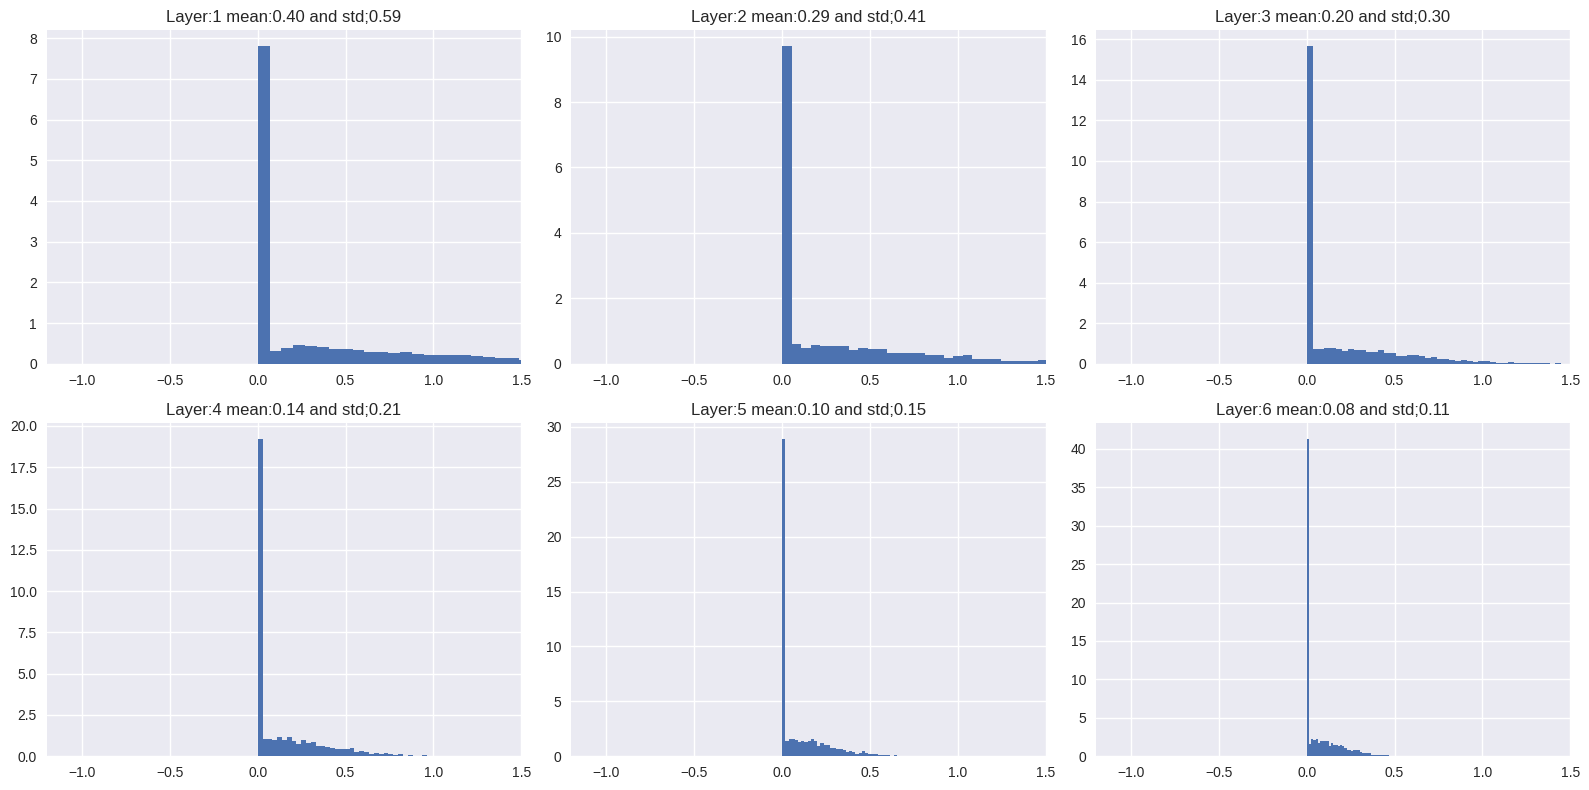

In [ ]:
dims = [4096]*7
mean = []
std =  []
hist = []
x = np.random.randn(dims[0])
for Din, Dout in zip(dims[:-1],dims[1:]):
    W = np.random.randn(Din,Dout)/np.sqrt(Din)
    x = np.maximum(0, x.dot(W))
    print(x.shape)
    mean.append(x.mean())
    std.append(x.std())
    hist.append(x)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
for i,ax,m,s in zip(np.arange(6),axes.flatten(),mean,std):
    ax.hist(hist[i],density = True,bins=50)
    ax.set_xlim(-1.2,1.5)
    ax.set_title(f'Layer:{i+1} mean:{m:.2f} and std;{s:.2f}')
plt.tight_layout()

Things aren't looking too good as most activations are again driven to zero on reaching the last layer. Let's try out Kaiming init now

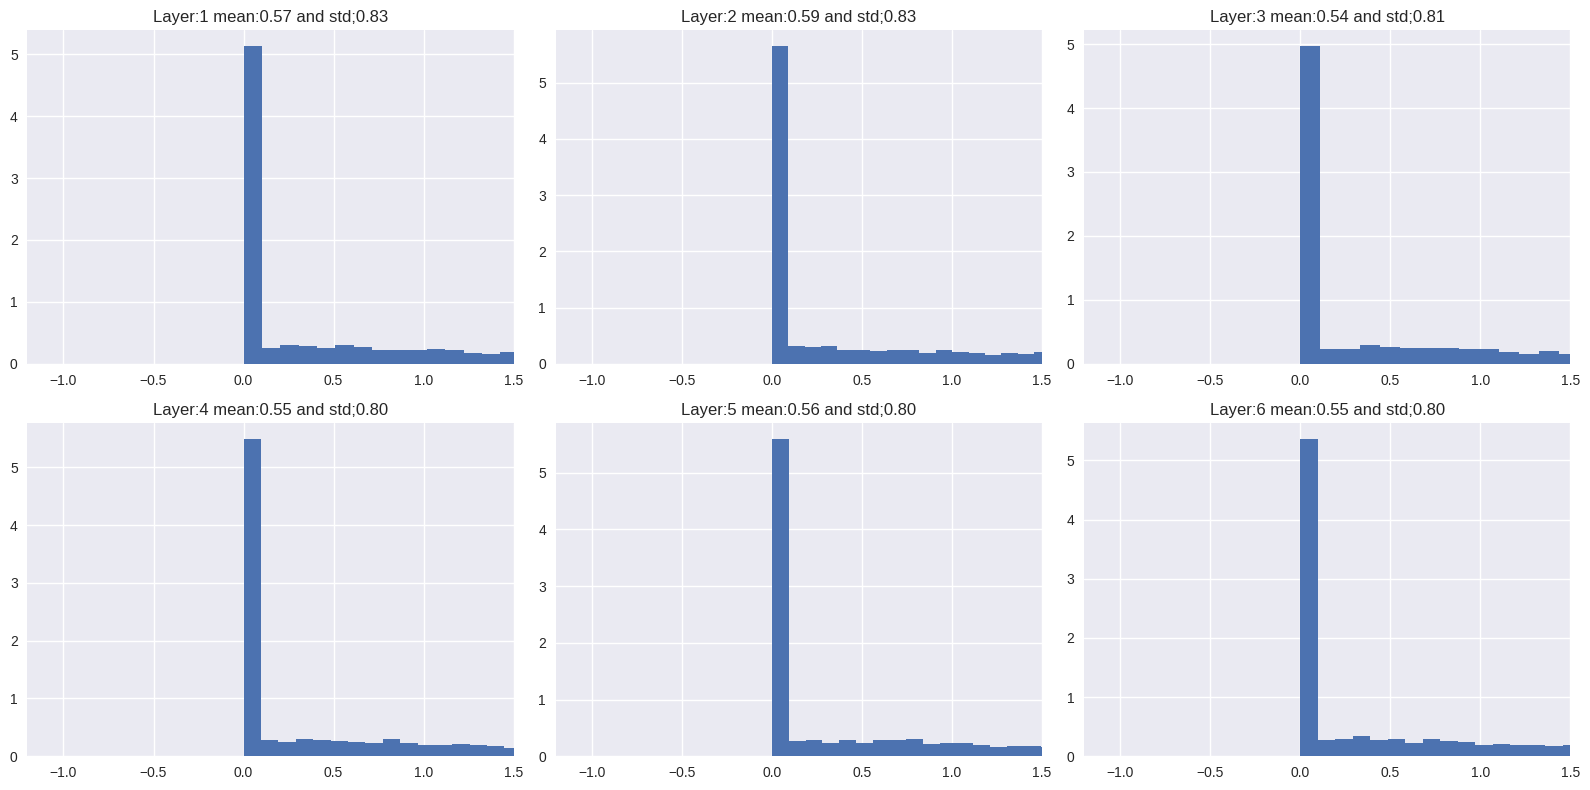

In [ ]:
dims = [4096]*7
mean = []
std =  []
hist = []
x = np.random.randn(dims[0])
for Din, Dout in zip(dims[:-1],dims[1:]):
    W = np.random.randn(Din,Dout)/np.sqrt(Din/2)
    x = np.maximum(0, x.dot(W))
    mean.append(x.mean())
    std.append(x.std())
    hist.append(x)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
for i,ax,m,s in zip(np.arange(6),axes.flatten(),mean,std):
    ax.hist(hist[i],density = True,bins=50)
    ax.set_xlim(-1.2,1.5)
    ax.set_title(f'Layer:{i+1} mean:{m:.2f} and std;{s:.2f}')
plt.tight_layout()

The activations look much better now

## A typical training loop in PyTorch

### Understanding how the data loader works

#### Dataset Class in PyTorch

```python
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]
```


### DataLoader

```python
from torch.utils.data import DataLoader

train_loader = DataLoader(
            train_dataset, # The samples in our dataset
            batch_size=16, # How many samples per batch to load
            shuffle=False, # Whether to shuffle the samples
            num_workers=4, # Number of cores that are used to prepare the batches (in parallel). 
        )
```

![image](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*ZNHDlhNnAFTsQwxJHteqUA.png)

In [ ]:
nlp_data = [
    {'tokenized_input': [1, 4, 5],
     'label':0},
    {'tokenized_input': [1, 7, 3],
     'label':0},
    {'tokenized_input': [1, 30, 67],
     'label':1},
    {'tokenized_input': [1, 17, 2],
     'label':0},
]
loader = DataLoader(nlp_data, batch_size=2, shuffle=False)
batch = next(iter(loader))
print(f'input: {batch["tokenized_input"]}')
print(f'label: {batch["label"]}')

input: [tensor([1, 1]), tensor([4, 7]), tensor([5, 3])]
label: tensor([0, 0])


In [ ]:
nlp_data = [
    {'tokenized_input': [1, 4, 5, 9, 3, 2],
     'label':0},
    {'tokenized_input': [1, 7, 3, 14, 48, 7, 23, 154, 2],
     'label':0},
    {'tokenized_input': [1, 30, 67, 117, 21, 15, 2],
     'label':1},
    {'tokenized_input': [1, 17, 2],
     'label':0},
]
loader = DataLoader(nlp_data, batch_size=2, shuffle=False)
batch = next(iter(loader))

RuntimeError: each element in list of batch should be of equal size

### What Caused the Error?

DataLoader stacks Torch Tensors in a batch. If the tensors are of different sizes, Pytorch would be unable to stack them into a batch (as the dimensions would not match). 

#### Easy Fix: 
Pad the tokens to the Max Length of tokens in the 'Entire Dataset' (A lot of wasted memory, and time.)

#### Better Fix: 
Pad the tokens to the Max Length of the tokens in the **'Batch'**

In [ ]:
from torch.nn.utils.rnn import pad_sequence

def custom_collate(data):
    inputs = [torch.tensor(d['tokenized_input']) for d in data]
    labels = [d['label'] for d in data]

    inputs = pad_sequence(inputs, batch_first=True)
    labels = torch.tensor(labels)

    return {
        'tokenized_input': inputs,
        'label': labels
    }

In [ ]:
loader = DataLoader(nlp_data, batch_size=2, 
shuffle=False, collate_fn=custom_collate) # Explicitly Tell DataLoader how to stack the data

iter_loader = iter(loader)
batch1 = next(iter_loader)
print(batch1, batch1['tokenized_input'].shape)
batch2 = next(iter_loader)
print(batch2, batch2['tokenized_input'].shape)

{'tokenized_input': tensor([[  1,   4,   5,   9,   3,   2,   0,   0,   0],
        [  1,   7,   3,  14,  48,   7,  23, 154,   2]]), 'label': tensor([0, 0])} torch.Size([2, 9])
{'tokenized_input': tensor([[  1,  30,  67, 117,  21,  15,   2],
        [  1,  17,   2,   0,   0,   0,   0]]), 'label': tensor([1, 0])} torch.Size([2, 7])


## Simple Training Loop


```python
model = MyNeuralNetwork(...)
optimizer = torch.optim.SGD(
  model.parameters(), lr=0.01, momentum=0.9
)

for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(train_loader):
            
        forward_pass_outputs = model(features)
        loss = loss_fn(forward_pass_outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
````

In the pseudo-code above, we have two for-loops to implement backpropagation with stochastic gradient descent-based optimization. The code nested under the inner for-loop (for batch_idx ...) defines a training step, which is also often just called “iteration.” In each iteration, we fetch a batch from the training dataset consisting of two tensors: the model inputs (features) and the targets. The model inputs are images in an image classification context, and the targets are the corresponding class labels.

Next, `model(features)` executes the forward pass that computes the model outputs, and it constructs a computation graph behind the scenes. Here, model is an arbitrary supervised learning model.

Via `loss_fn`, we then carry out a computation that measures the difference between the model outputs and the desired target values. This computation is added to the computation graph that exists behind the scenes.

The following lines are where it gets interesting as they define the backpropagation procedure for training the neural network:

```python
optimizer.zero_grad()
loss.backward()
optimizer.step()
```


The optimizer is typically an object for gradient descent-based optimization, for example, standard stochastic gradient descent, ADAM, etc.

When we perform backpropagation, PyTorch allows us to accumulate gradients -- i.e., we can call `loss.backward()` multiple times and the gradients will be added to the existing gradients. 

We have to manually ensure that the gradients are reset to zero at in each backpropagation round. We do this via optimizer.zero_grad().

Calling `loss.backward()` will run reverse mode automatic differentiation on the computation graph defined in the forward pass (model(features) & loss_fn(...)). Calling `loss.backward()` will compute the gradient of the loss with respect to the weights, which are needed to update the weights using stochastic gradient descent, which happens in the next step when we call `optimizer.step()`.

Finally, the outer for-loop (for epoch in range(num_epochs):) repeats the batch iteration and training steps for multiple passes over the training set (epoch is really just a fancy term for defining a pass over a training set, visiting each training example exactly once.)

### Summary

To recap and summarize, a typical training loop in PyTorch iterates over the batches for a given number of epochs. In each batch iteration, we first compute the forward pass to obtain the neural network outputs:

```python
forward_pass_outputs = model(features)
loss = loss_fn(forward_pass_outputs, targets)
```

Then, we reset the gradient from the previous iteration and perform backpropagation to obtain the gradient of the loss with respect to the model weights:
    
```python
optimizer.zero_grad()
loss.backward()
```

Finally, we update the model weights using the optimizer:

```python
optimizer.step()
```

### A Custom Dataset Class in Practice

In [ ]:
import torch
from torch.utils.data import Dataset
import json
import os
from PIL import Image

class PascalVOCDataset(Dataset):
    """
    A PyTorch Dataset class for the Pascal VOC dataset.
    This class is used with a PyTorch DataLoader to load images and their corresponding annotations (bounding boxes, labels, difficulties).
    """

    def __init__(self, data_folder, split, keep_difficult=False):
        """
        Initializes the dataset.

        :param data_folder: Path to the folder where preprocessed dataset files are stored.
        :param split: Dataset split, either 'TRAIN' or 'TEST'.
        :param keep_difficult: If False, excludes objects labeled as 'difficult' (hard to detect objects).
        """

        self.split = split.upper()  # Ensure the split string is uppercase

        assert self.split in {'TRAIN', 'TEST'}, "split must be either 'TRAIN' or 'TEST'"

        self.data_folder = data_folder
        self.keep_difficult = keep_difficult

        # Load image file paths and corresponding object annotations from preprocessed JSON files.
        with open(os.path.join(data_folder, self.split + '_images.json'), 'r') as j:
            self.images = json.load(j)  # List of image file paths
        with open(os.path.join(data_folder, self.split + '_objects.json'), 'r') as j:
            self.objects = json.load(j)  # List of object annotations (bounding boxes, labels, difficulties)

        assert len(self.images) == len(self.objects), "Mismatch between images and object annotations"

    def __getitem__(self, i):
        """
        Returns the i-th sample from the dataset.

        :param i: Index of the sample to retrieve.
        :return: Tuple (image, boxes, labels, difficulties)
        """

        # Load image using PIL (Python Imaging Library)
        image = Image.open(self.images[i], mode='r')  # Open the image file
        image = image.convert('RGB')  # Ensure the image is in RGB format

        # Retrieve object annotations (bounding boxes, labels, difficulties)
        objects = self.objects[i]
        boxes = torch.FloatTensor(objects['boxes'])  # Bounding box coordinates (n_objects, 4)
        labels = torch.LongTensor(objects['labels'])  # Class labels for each object (n_objects)
        difficulties = torch.ByteTensor(objects['difficulties'])  # Difficulty labels (n_objects), 1 if difficult, 0 otherwise

        # Remove objects labeled as 'difficult' if not using them for training
        if not self.keep_difficult:
            boxes = boxes[1 - difficulties]  # Keep only non-difficult boxes
            labels = labels[1 - difficulties]  # Keep only non-difficult labels
            difficulties = difficulties[1 - difficulties]  # Keep only non-difficult difficulties

        # Apply dataset-specific transformations (e.g., resizing, normalization, augmentation)
        image, boxes, labels, difficulties = transform(image, boxes, labels, difficulties, split=self.split)

        return image, boxes, labels, difficulties  # Return transformed image and its annotations

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.images)

    def collate_fn(self, batch):
        """
        Custom collate function to handle variable-sized targets (bounding boxes, labels).

        PyTorch's default collate function does not support variable-sized tensors (e.g., different numbers of objects per image).
        We return lists for boxes, labels, and difficulties instead of stacking them into a single tensor.

        :param batch: A batch of N samples, where each sample is (image, boxes, labels, difficulties).
        :return: A tuple containing:
            - Tensor of stacked images: shape (N, 3, H, W)
            - List of bounding boxes (each list item is a tensor of shape (n_objects, 4))
            - List of labels (each list item is a tensor of shape (n_objects,))
            - List of difficulty flags (each list item is a tensor of shape (n_objects,))
        """

        images = list()
        boxes = list()
        labels = list()
        difficulties = list()

        # Iterate through the batch and separate images and annotations
        for b in batch:
            images.append(b[0])  # Image tensor
            boxes.append(b[1])   # List of bounding box tensors
            labels.append(b[2])  # List of label tensors
            difficulties.append(b[3])  # List of difficulty tensors

        # Stack all images into a single tensor with shape (batch_size, 3, H, W)
        images = torch.stack(images, dim=0)

        return images, boxes, labels, difficulties  # Return images and annotations as separate lists

Reference: https://adityassrana.github.io/blog/theory/2020/08/26/Weight-Init.html